## Convocatoria 1 - Proyecto 1

#### 0) Cargar una de las imágenes histológicas

In [ ]:
# Obtener las imagen 'histo_x.jpg'

In [1]:
# Implementamos el acceso a los .jpg de manera comoda.
# si no está intalado "pip install requests"
import requests
# URL directa a la imagen en bruto
image_url1 = "https://raw.githubusercontent.com/JLRRC/MASTERIA/main/05MIAR_Aprendizaje_Supervisado/Act/histo_1.jpg"
output_path1 = "histo_1.jpg"  # Nombre para guardar la imagen localmente
image_url2 = "https://raw.githubusercontent.com/JLRRC/MASTERIA/main/05MIAR_Aprendizaje_Supervisado/Act/histo_2.jpg"
output_path2 = "histo_2.jpg"  # Nombre para guardar la imagen localmente

# Descargar la imagen1
response = requests.get(image_url1)
if response.status_code == 200:
    with open(output_path1, "wb") as file:
        file.write(response.content)
    print(f"Imagen descargada exitosamente como: {output_path1}")
else:
    print(f"Error al descargar la imagen. Código de estado: {response.status_code}")

# Descargar la imagen2
response = requests.get(image_url2)
if response.status_code == 200:
    with open(output_path2, "wb") as file:
        file.write(response.content)
    print(f"Imagen descargada exitosamente como: {output_path2}")
else:
    print(f"Error al descargar la imagen. Código de estado: {response.status_code}")

Imagen descargada exitosamente como: histo_1.jpg
Imagen descargada exitosamente como: histo_2.jpg


# **SECCIÓN 01 - Para la imagen histo_2.jpg**

In [2]:
# Utilizar la librería skimage.io para leer la imagen 'histo_x.jpg' en formato RGB.
# Normalizar la imagen para que los píxeles se encuentren en el rango [0, 1]
# Visualizar la imagen

In [16]:
# Importar las librerías necesarias; skimage y matplotlib
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, filters, img_as_ubyte, color, measure, morphology
from skimage.filters import gaussian, threshold_otsu
from skimage.segmentation import flood
from skimage.util import img_as_ubyte
from skimage.measure import label, regionprops
from scipy.ndimage import binary_fill_holes
import pandas as pd
from tabulate import tabulate


# Leer la imagen en formato RGB
#image_path = "histo_1.jpg"
image_path = "histo_2.jpg"
image = io.imread(image_path)

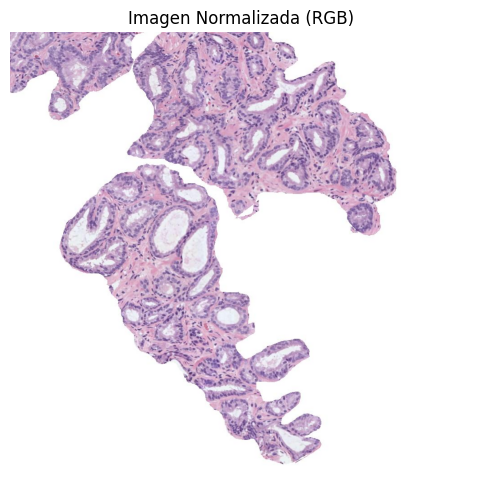

In [4]:
# Normalizar la imagen para que los píxeles se encuentren en el rango [0, 1]
image_normalized = image / 255.0

# Visualizar la imagen
plt.figure(figsize=(6, 6))
plt.imshow(image_normalized)
plt.title("Imagen Normalizada (RGB)")
plt.axis("off")
plt.show()

#### 1) Realizar una transformación de color para convertir la imagen al espacio de color CMYK

In [ ]:
# Extraer la componente magenta de la imagen (que corresponde a la región tisular)
# Visualizar la imagen del canal magenta

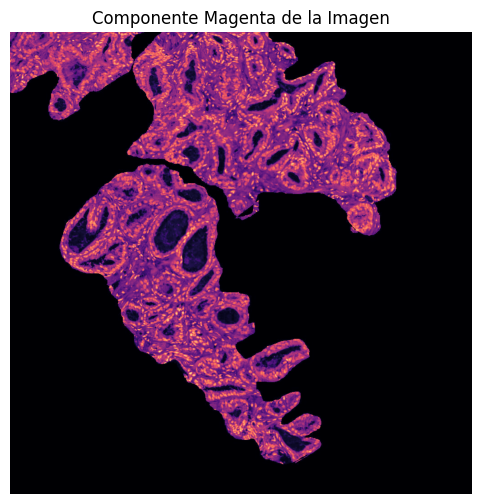

In [5]:
# Normalizar los canales RGB al rango [0, 1]
red_channel = image_normalized[:, :, 0]
green_channel = image_normalized[:, :, 1]
blue_channel = image_normalized[:, :, 2]

# Calcular los valores CMY
cyan = 1 - red_channel
magenta = 1 - green_channel
yellow = 1 - blue_channel

# Ajustar la fórmula para obtener el canal Magenta en CMYK
magenta_component = magenta

# Visualizar la imagen normalizada del canal magenta
plt.figure(figsize=(6, 6))
plt.imshow(magenta_component, cmap='magma')
plt.title("Componente Magenta de la Imagen")
plt.axis("off")
plt.show()

#### 2) Umbralizar la imagen para separar los píxeles del fondo de la región tisular

In [ ]:
# Aplicar un filtro gaussiano de tamaño 5x5 y después utilizar el método de Otsu de manera que
# los píxeles correspondientes al lumen y al background de la imagen sean 1s y el resto de los píxeles tengan un valor de 0.
# Nota: Recordar que el método de Otsu requiere como input una imagen en el rango [0-255] en formato "uint8".
# Visualizar la máscara resultante

Umbral calculado por Otsu: 49


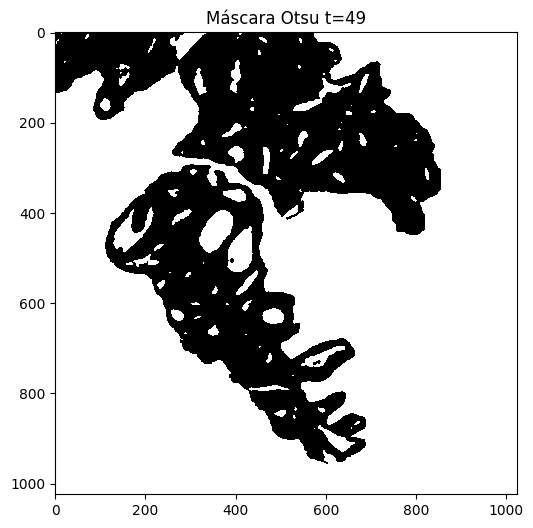

Valores únicos en la máscara: [False  True]


In [7]:
# Aplicar un filtro gaussiano con sigma ajustado
gaussian_filtered = gaussian(magenta_component, sigma=2.0, mode='reflect')  # Ajustar sigma

# Convertir la imagen al rango [0, 255] en formato uint8
gaussian_filtered_uint8 = img_as_ubyte(gaussian_filtered)

# Calcular el umbral de Otsu
otsu_threshold = threshold_otsu(gaussian_filtered_uint8)
print(f"Umbral calculado por Otsu: {otsu_threshold}")

# Crear la máscara binaria (invertida para que lumen y fondo sean 1s)
binary_mask = gaussian_filtered_uint8 < otsu_threshold  # Invertimos el criterio

# Visualizar la máscara binaria
plt.figure(figsize=(6, 6))
plt.imshow(binary_mask, cmap='gray', interpolation='nearest')
plt.title(f"Máscara Otsu t={otsu_threshold}")
plt.axis("on")  # Mostrar ejes para referencia
plt.show()

# Verificar los valores únicos en la máscara para asegurarnos que son 0s y 1s
unique_values = np.unique(binary_mask)
print(f"Valores únicos en la máscara: {unique_values}")

#### 3) Limpiar la imagen eliminando los artefactos de lumen (objetos blancos pequeños que no son lúmenes)

In [ ]:
# Utilizar la librería skimage.morphology.remove_small_objects para eliminar aquellos objetos cuya área sea menor a 300 píxeles
# Más información en https://scikit-image.org/docs/dev/api/skimage.morphology.html#skimage.morphology.remove_small_objects
# Visualizaer la máscara resultante

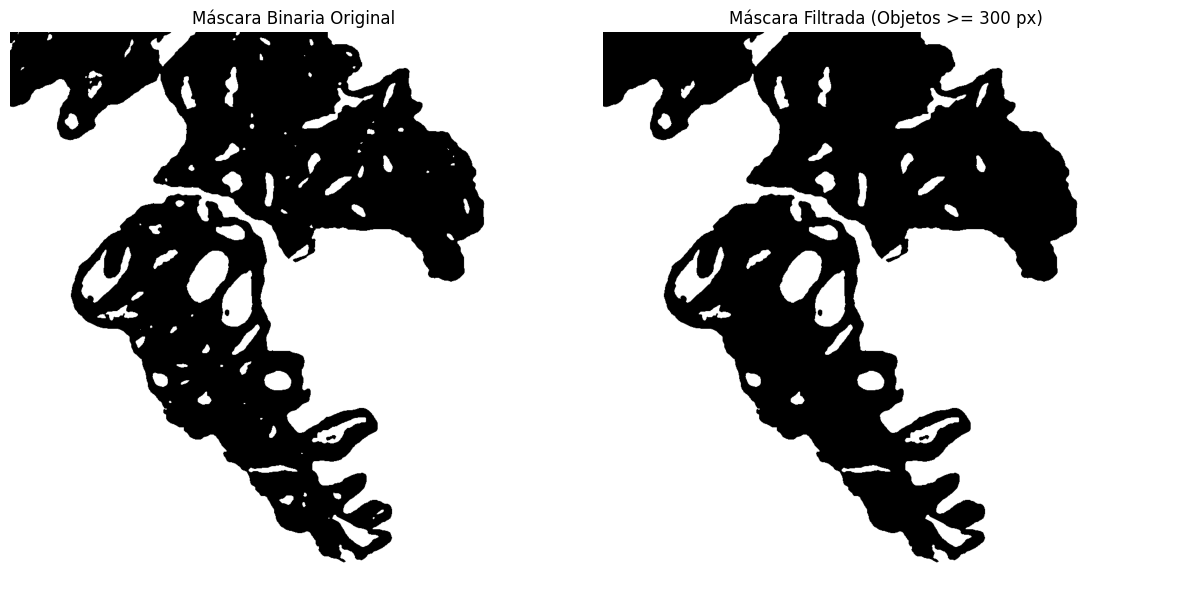

<Figure size 600x600 with 0 Axes>

In [19]:
# Eliminar objetos pequeños (área menor a 300 píxeles), usamos la "mascata binaria"
filtered_mask = morphology.remove_small_objects(binary_mask, min_size=300)

# Visualizar la máscara original y la máscara filtrada
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].imshow(binary_mask, cmap="gray")
ax[0].set_title("Máscara Binaria Original")
ax[0].axis("off")

ax[1].imshow(filtered_mask, cmap="gray")
ax[1].set_title("Máscara Filtrada (Objetos >= 300 px)")
ax[1].axis("off")

plt.tight_layout()
plt.figure(figsize=(6, 6))
plt.show()

#### 4) Rellenar con 0s el fondo de la imagen para quedarnos únicamente con los lúmenes

In [ ]:
# Aplicar el algoritmo de expansión a partir de semillas (region growing) de manera que únicamente los lúmenes sean blancos
# y el resto de la imagen negra. Pista: utilizar dos semillas. Nota: Se pueden fijar las semillas de manera manual, pero
# se valorará positivamente a aquell@s que desarrollen una función para encontrarlas automáticamente.
# Visualizar la máscara resultante.

Semillas detectadas (ordenadas por área): [(590, 549), (440, 357), (486, 411), (444, 166), (22, 289), (141, 587), (904, 624), (720, 590), (629, 483), (361, 400), (99, 399), (269, 402), (112, 320), (556, 426), (283, 467), (276, 590), (508, 201), (789, 474), (407, 279), (217, 394), (627, 271), (161, 111), (234, 547), (111, 683), (662, 350), (104, 151), (238, 681), (321, 629)]
Semillas seleccionadas (sin las dos primeras): [(440, 357), (486, 411), (444, 166), (22, 289), (141, 587), (904, 624), (720, 590), (629, 483), (361, 400), (99, 399), (269, 402), (112, 320), (556, 426), (283, 467), (276, 590), (508, 201), (789, 474), (407, 279), (217, 394), (627, 271), (161, 111), (234, 547), (111, 683), (662, 350), (104, 151), (238, 681), (321, 629)]


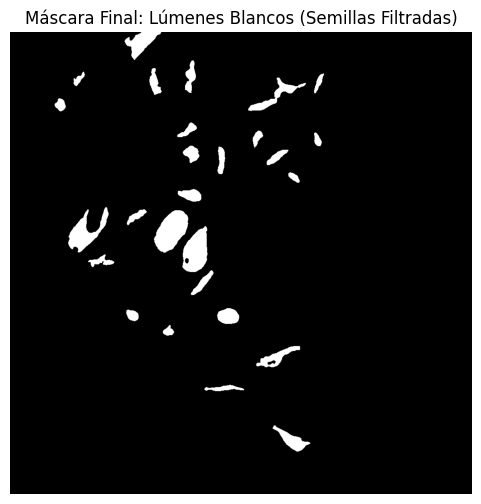

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.measure import label, regionprops
from skimage.segmentation import flood

# Función para detectar todas las regiones y ordenar las semillas
def find_and_sort_seeds(mask, num_seeds=None, sort_by='area', ascending=True):
    """
    Encuentra todas las semillas basadas en las regiones conectadas y las ordena.
    Args:
        mask: Máscara binaria.
        num_seeds: Número máximo de semillas a devolver (opcional).
        sort_by: Criterio de ordenación ('area' o 'centroid').
        ascending: Orden ascendente o descendente.
    Returns:
        Lista de coordenadas (fila, columna) de las semillas ordenadas.
    """
    labeled_mask = label(mask)
    regions = regionprops(labeled_mask)

    # Ordenar las regiones según el criterio elegido
    if sort_by == 'area':
        sorted_regions = sorted(regions, key=lambda r: r.area, reverse=not ascending)
    elif sort_by == 'centroid':
        sorted_regions = sorted(regions, key=lambda r: r.centroid[0], reverse=not ascending)
    else:
        raise ValueError("Criterio de ordenación no válido: use 'area' o 'centroid'.")

    # Obtener las coordenadas de las semillas
    seeds = [tuple(map(int, region.centroid)) for region in sorted_regions]

    # Limitar al número máximo de semillas si se especifica
    if num_seeds is not None:
        seeds = seeds[:num_seeds]
    return seeds

# Algoritmo de crecimiento de regiones
def region_growing(mask, seeds):
    """
    Aplica crecimiento de región a partir de las semillas dadas.
    Args:
        mask: Máscara binaria.
        seeds: Lista de coordenadas de semillas.
    Returns:
        Máscara binaria con las regiones crecidas.
    """
    region_mask = np.zeros_like(mask, dtype=bool)
    for seed in seeds:
        if mask[seed]:  # Verifica que la semilla está en una región válida
            region = flood(mask, seed_point=seed)
            region_mask |= region  # Combina las regiones crecidas
    return region_mask

# Detectar y ordenar semillas por área (descendente)
sorted_seeds = find_and_sort_seeds(filtered_mask, sort_by='area', ascending=False)
print(f"Semillas detectadas (ordenadas por área): {sorted_seeds}")

# Excluir las dos primeras semillas que no nos valen.
if len(sorted_seeds) > 2:
    filtered_seeds = sorted_seeds[1:]  # Excluir las dos primeras
else:
    filtered_seeds = sorted_seeds  # Si hay menos de tres semillas, mantener todas

#filtered_seeds = sorted_seeds
print(f"Semillas seleccionadas (sin las dos primeras): {filtered_seeds}")

# Aplicar crecimiento de región desde las semillas seleccionadas
lumen_mask = region_growing(filtered_mask, filtered_seeds)

# Visualizar la máscara final con los lúmenes blancos
plt.figure(figsize=(6, 6))
plt.imshow(lumen_mask, cmap="gray")
plt.title("Máscara Final: Lúmenes Blancos (Semillas Filtradas)")
plt.axis("off")
plt.show()

#### 5) Rellenar los objetos de los lúmenes

In [ ]:
# Rellenar los lúmenes con la función binary_fill_holes de la librería scipy.ndimage.morphology
# Visualizar la máscara resultante

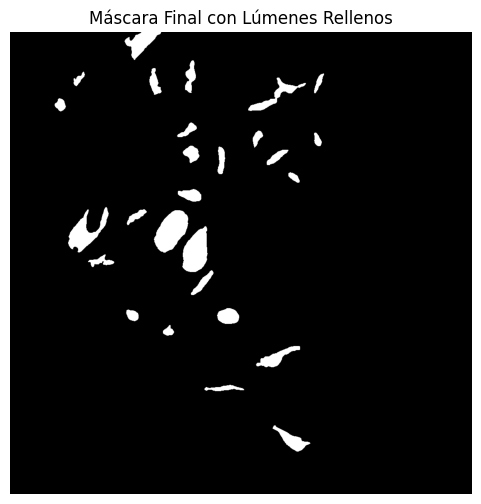

In [10]:
# Rellenar los lúmenes con la función binary_fill_holes
filled_mask = binary_fill_holes(lumen_mask)

# Visualizar la máscara resultante
plt.figure(figsize=(6, 6))
plt.imshow(filled_mask, cmap="gray")
plt.title("Máscara Final con Lúmenes Rellenos")
plt.axis("off")
plt.show()

#### 6) Detectar y dibujar los contornos de los lúmenes sobre la imagen original

In [ ]:
# Dibujar los contornos de los lúmenes en color verde sobre la imagen original RGB. Nota: Utilizar los flags necesarios
# para que los contornos en verde sean perfectamente visibles.
# Visualizar la imagen superpuesta

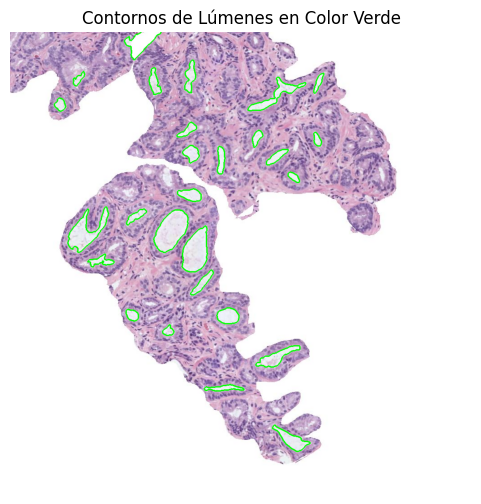

In [11]:
# Encontrar los contornos de los lúmenes
contours = measure.find_contours(filled_mask, level=0.5)

# Crear una copia de la imagen original para superponer los contornos
image_with_contours = np.copy(image_normalized)

# Dibujar los contornos en verde (modificando directamente los píxeles)
for contour in contours:
    for y, x in contour:
        y, x = int(y), int(x)
        # Validar que las coordenadas estén dentro de los límites de la imagen
        if 0 <= y < image_with_contours.shape[0] and 0 <= x < image_with_contours.shape[1]:
            image_with_contours[y, x] = [0, 255, 0]  # Verde en formato RGB
            # Píxeles adyacentes para grosor
            if y + 1 < image_with_contours.shape[0]:
                image_with_contours[y + 1, x] = [0, 255, 0]
            if y - 1 >= 0:
                image_with_contours[y - 1, x] = [0, 255, 0]
            if x + 1 < image_with_contours.shape[1]:
                image_with_contours[y, x + 1] = [0, 255, 0]
            if x - 1 >= 0:
                image_with_contours[y, x - 1] = [0, 255, 0]

# Visualizar la imagen con contornos superpuestos
plt.figure(figsize=(6, 6))
plt.imshow(image_with_contours)
plt.title("Contornos de Lúmenes en Color Verde")
plt.axis("off")
plt.show()

#### 7) Identificar y cropear el lumen más grande

In [ ]:
# Determinar cuál es el lumen de mayor área y hacer un crop del mismo sobre la imagen original RGB.
# Visualizar el lumen cropeado.

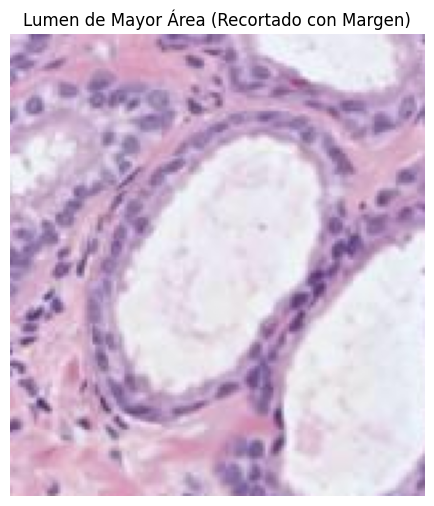

In [13]:
# Etiquetar las regiones conectadas en la máscara binaria
labeled_mask = measure.label(filled_mask)

# Calcular las propiedades de las regiones conectadas
regions = measure.regionprops(labeled_mask)

# Verificar si se encontraron regiones
if not regions:
    raise ValueError("No se encontraron regiones conectadas en la máscara.")

# Encontrar la región de mayor área
largest_region = max(regions, key=lambda r: r.area)

# Obtener las coordenadas de la bounding box de la región más grande
min_row, min_col, max_row, max_col = largest_region.bbox

# Definir un margen en píxeles
margin = 40

# Ajustar las coordenadas del bounding box para incluir el margen
min_row = max(min_row - margin, 0)  # Evitar que sea menor que 0
min_col = max(min_col - margin, 0)
max_row = min(max_row + margin, image_normalized.shape[0])  # Evitar que exceda el tamaño de la imagen
max_col = min(max_col + margin, image_normalized.shape[1])

# Validar que las coordenadas de la bounding box estén dentro de los límites de la imagen original
if max_row > image_normalized.shape[0] or max_col > image_normalized.shape[1]:
    raise ValueError("La bounding box excede las dimensiones de la imagen original.")

# Recortar el lumen más grande de la imagen original RGB con el margen incluido
cropped_lumen = image_normalized[min_row:max_row, min_col:max_col]

# Visualizar el lumen recortado
plt.figure(figsize=(6, 6))
plt.imshow(cropped_lumen)
plt.title("Lumen de Mayor Área (Recortado con Margen)")
plt.axis("off")
plt.show()

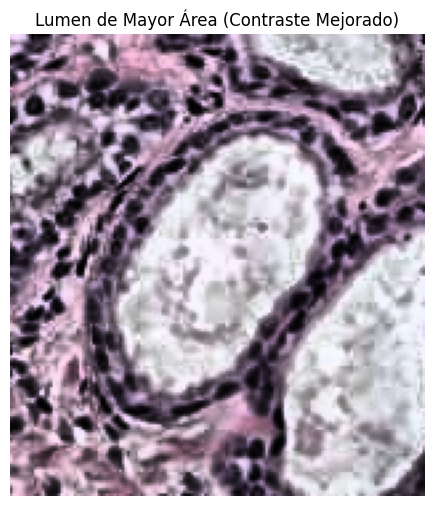

In [14]:
from skimage import exposure

# Ajustar el contraste con "equalize_adapthist" para un mejor contraste local
adjusted_cropped_lumen = exposure.equalize_adapthist(cropped_lumen, clip_limit=0.03)

# Mostrar la imagen mejorada
plt.figure(figsize=(6, 6))
plt.imshow(adjusted_cropped_lumen, cmap="gray")  # Usa cmap="gray" para imágenes en escala de grises
plt.title("Lumen de Mayor Área (Contraste Mejorado)")
plt.axis("off")
plt.show()

#### 8) Extraer 13 características geométricas que permitan caracterizar el lumen recortado

In [ ]:
# Calcular las siguientes características del crop del lumen de mayor área, redondeando su valor hasta el cuarto decimal.
# 1) Área
# 2) Área de la bounding box
# 3) Área convexa
# 4) Exentricidad
# 5) Diámetro equivalente
# 6) Extensión
# 7) Diámetro Feret
# 8) Longitud del eje mayor
# 9) Longitud del eje menor
# 10) Orientación
# 11) Perímetro
# 12) Solidez
# 13) Compacidad

In [18]:
# Verificar si se encontraron regiones conectadas en la máscara
if not regions:
    raise ValueError("No se encontraron regiones conectadas en la máscara binaria.")

# Identificar la región de mayor área
largest_region = max(regions, key=lambda r: r.area)

# Calcular las características geométricas
area = largest_region.area  # Área de la región
bounding_box_area = (largest_region.bbox[2] - largest_region.bbox[0]) * (largest_region.bbox[3] - largest_region.bbox[1])  # Área de la bounding box
convex_area = largest_region.convex_area  # Área convexa
eccentricity = largest_region.eccentricity  # Excentricidad
equivalent_diameter = largest_region.equivalent_diameter  # Diámetro equivalente
extent = largest_region.extent  # Extensión
feret_diameter = max(largest_region.major_axis_length, largest_region.minor_axis_length)  # Diámetro de Feret
major_axis_length = largest_region.major_axis_length  # Longitud del eje mayor
minor_axis_length = largest_region.minor_axis_length  # Longitud del eje menor
orientation = largest_region.orientation  # Orientación
perimeter = largest_region.perimeter  # Perímetro
solidity = largest_region.solidity  # Solidez
compactness = (perimeter ** 2) / (4 * np.pi * area)  # Compacidad

# Mostrar los resultados
#print("Características del Lumen de Mayor Área:")
#print(f"1) Área: {round(area, 4)}")
#print(f"2) Área de la Bounding Box: {round(bounding_box_area, 4)}")
#print(f"3) Área Convexa: {round(convex_area, 4)}")
#print(f"4) Excentricidad: {round(eccentricity, 4)}")
#print(f"5) Diámetro Equivalente: {round(equivalent_diameter, 4)}")
#print(f"6) Extensión: {round(extent, 4)}")
#print(f"7) Diámetro Feret: {round(feret_diameter, 4)}")
#print(f"8) Longitud del Eje Mayor: {round(major_axis_length, 4)}")
#print(f"9) Longitud del Eje Menor: {round(minor_axis_length, 4)}")
#print(f"10) Orientación: {round(orientation, 4)}")
#print(f"11) Perímetro: {round(perimeter, 4)}")
#print(f"12) Solidez: {round(solidity, 4)}")
#print(f"13) Compacidad: {round(compactness, 4)}")

# Lista de características y valores
caracteristicas = [
    "Área",
    "Área de la bounding box",
    "Área convexa",
    "Excentricidad",
    "Diámetro equivalente",
    "Extensión",
    "Diámetro Feret",
    "Longitud del eje mayor",
    "Longitud del eje menor",
    "Orientación",
    "Perímetro",
    "Solidez",
    "Compacidad",
]

valores = [
    area,
    bounding_box_area,
    convex_area,
    eccentricity,
    equivalent_diameter,
    extent,
    feret_diameter,
    major_axis_length,
    minor_axis_length,
    orientation,
    perimeter,
    solidity,
    compactness,
]

# Crear un DataFrame con los datos
data = pd.DataFrame({"Características": caracteristicas, "Valor": valores})

# Redondear los valores a 4 decimales
data["Valor"] = data["Valor"].round(4)

# Mostrar la tabla en un formato similar al de tu imagen
print(tabulate(data, headers="keys", tablefmt="grid"))

+----+-------------------------+-----------+
|    | Características         |     Valor |
+====+=========================+===========+
|  0 | Área                    | 4569      |
+----+-------------------------+-----------+
|  1 | Área de la bounding box | 7144      |
+----+-------------------------+-----------+
|  2 | Área convexa            | 4702      |
+----+-------------------------+-----------+
|  3 | Excentricidad           |    0.839  |
+----+-------------------------+-----------+
|  4 | Diámetro equivalente    |   76.2721 |
+----+-------------------------+-----------+
|  5 | Extensión               |    0.6396 |
+----+-------------------------+-----------+
|  6 | Diámetro Feret          |  103.638  |
+----+-------------------------+-----------+
|  7 | Longitud del eje mayor  |  103.638  |
+----+-------------------------+-----------+
|  8 | Longitud del eje menor  |   56.3997 |
+----+-------------------------+-----------+
|  9 | Orientación             |   -0.5639 |
+----+----